In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dynamics_model_4groups import dynamics_model

# The Vaccine Allocation Problem
## Description

Given a limited number of available vaccines and a population undergoing an epidemic, how do we distribute vaccines to the population in a way that achieves some goal (like minimizing death or maximizing the potential for herd immunity)? The vaccine allocation or allotment problem considers the question: If we divide the population into different groups or risk classes, is there an *optimal* way to allocate the vaccines across these groups so that we minimize infections, deaths or hospitalizations? We approach this problem from a reinforcement learning perspective. 

## 4 Groups with Finite Action and Finite State Spaces

The file `vacc_4groups.py` contains an implemenation of an RL environment for the vaccine allotment problem with 4 possible risk groups, a finite action space, and a finite state space. In this problem, we consider a scenario where the agent chooses a *priority order* of the 4 risk groups. This means that vaccines are allocated in a particular order until there are no more vaccines. In other words, vaccines are given to eligbile recipients of priority group \#1 until there are no eligible recipients left or the vaccine supply is exhausted. If there are vaccines left after all eligible people priority group \#1 are vaccinated, then priority group \#2 can be vaccinated and so on. 

### Reinforcement Learning Problem Setup

**Markov Decision Process (MDP)**

At each time step $t$ in the RL environement, we have a population of size $P$ split into four classes $C_1^t, C_2^t, C_3^t$ and $C_4^t$. Here, $C_i^t$ denotes the size of class $i$ at time $t$. 

We further split each class $C_i$ into two groups: susceptbile $(S_i^t)$ and asymptomatically infected $(A_i^t)$. We keep track of the aggregate totals of symptomatically infected individuals, both mild ($I^t$) and requiring hospitalization ($H^t$). 

For each time period $t$, we also keep track of *new* infections that have occurred since time step $t-1$. We define this as 
$$ N^t \equiv \left(I^{t} + H^{t} + \sum_{i=1}^{4} A_i^t\right) - \left(I^{t-1} + H^{t-1} + \sum_{i=1}^{4} A_i^{t-1}\right). $$ In other words, we take the total number of infections at time $t$ and subtract the total number of infections from time $t-1$ to determine how many infections are *new*.

We form the MDP $(\mathcal{S}, \mathcal{A}, \mathcal{T}, \mathcal{R})$ where
+ The ***state space*** $\mathcal{S}$ is defined as $\mathcal{S} := [P]^{11}$ with $[P] := \{0, 1, 2, \ldots, P\}$. Recall that $P$ is the total population size. Each tuple in the space is of the form $$\left(S_1^t, S_2^t, S_3^t, S_4^t, A_1^t, A_2^t, A_3^t, A_4^t, I^t, H^t, N^t\right),$$ and thus tells us how many people are suceptible, infected and to which group they belong (if applicable) at time step $t$.
+ The ***action space*** is defined by $$\mathcal{A} := \{a|a = \text{ a permutation of the numbers 1, 2, 3, 4} \quad \text{or} \quad a = \text{ an empty list }\}$$ where a permuation of $\{1,2,3,4\}$ defines a priority order of the 4 classes and an empty list defines "no priority order," aka random vaccination.
+ The ***transition dynamics*** $\mathcal{T}$ are given by the transitions in the continuous time Markov chain (CTMC) specified below.
> The state space of the CTMC is almost exactly the same as the MDP. The state space in this case is also $[P]^{11}$, but in this case a state at a time $t$ is of the form
$$\left(S_1^t, S_2^t, S_3^t, S_4^t, A_1^t, A_2^t, A_3^t, A_4^t, I^t, H^t, R^t\right).$$ The difference being that instead of the $N^t$ term in the state space of the MDP, we have an $R^t$ term, where $R^t$ denotes the number of recovered individuals at a given time $t$. Recovered individuals include anyone who has been vaccinated and anyone who has recovered from infection.
>
> The initial state $(S_1^0, S_2^0, S_3^0, S_4^0, A_1^0, A_2^0, A_3^0, A_4^0, I^0, H^0, R^0)$ is specified as an initial condition by the user.
>
> All events in this CTMC are implemented as independent Poisson processes. For example, the times between meetings for all the groups (i.e. an interaction between group $i$ and group $j$) are given by Poisson processes with rates specified by the user. In this case, we must specify a $4 \times 4$ *contact* matrix $\Lambda$ where the $(i,j)$th component corresponds to the meeting rate between the $i$th and $j$th groups. 
> > Only infectious meetings are calculated, meaning we only keep track of meetings between infected individuals and susceptible individuals. Each rate is a rate between two people, so we have to scale the meeting rates by the number of people in each class. This means that the rates change over time.  Once a person in class $i$ has been infected, they have probability $p_i$ of developing symptoms. If a person in class $i$ develops symptoms, they have probability $h_i$ of those symptoms requiring hospitalization.
>
> There is also a recovery rate $\beta$ and a vaccination rate $\gamma$. The vaccination rate corresponds to the average number of people that can be vaccinated per day and remains constant. However, the recovery rate is scaled by the number of people who are infected and thus changes over time.
>
> Each individual Poisson process has an associated exponetial random variable "clock" with the same rate as the Poisson process. This gives us a collection of exponential timers. The minimum of several independent exponential random variables is also an exponential random variable, but with a rate equal to the sum of all the rates of the independent exponential random variables. Therefore, to calculate the time of the next event, we sum up the meeting, recovery, and vaccination rates and pass this sum as the rate of an exponential random variable.

+ The ***reward*** (or *cost*, in this case) $\mathcal{R}$ recieved after transitioning from state $s$ to state $s'$ due to an action $a$ is equal to negative one times the total number of infections in state $s'$ minus the total number of infections at state $s$, aka the new infections that occurred during this transition. If $s = s_{t-1}$ is the state at time $t-1$ and $s' = s'_t$ is the state at time $t$, then $\mathcal{R}_a(s,s') = -N^t$.

**Model Assumptions** 
The total population is kept constant throughout the entire time horizon. 
There are precisely 4 risk classes, with the first class corresponding to medical workers.
Vaccines are administered by priority group. The first priority group is vaccinated until there are either no more eligible vaccination candidates or there are no more vaccines. If vaccines remain, the next priority group is vaccinated and so on. Asymptomatic individuals are never vaccinated. 
>For details about the assumptions made in implementing the SIR disease dynamics model, please refer to the section titled **Disease Dynamics** below.

**State Space**

The state space for this environment is discrete, consisting of tuples of integer values representing certain population stats. 
> In this case, an element of the state space looks like $$(S_1, S_2, S_3, S_4, A_1, A_2, A_3, A_4, I, H, N) \in \{0,1,2,...,\text{P}\}^{11}$$ where 
> + $P =$ the total population size
> + $S_1,S_2,S_3,S_4 =$ the total # of susceptible people in groups 1, 2, 3 and 4, resp
> + $A_1,A_2,A_3,A_4 =$ the total # of asymptomatically infected people in groups 1, 2, 3 and 4, resp
> + $I =$ total # of mild symptomatic infections
> + $H =$ total # of hospitalized infections and 
> + $N =$ total # of NEW infections (includes asymptomatic and symptomatic) that occurred.

**Action Space**

The action space for this environment is finite, consisting of 25 possible actions. An action in this space is choosing a priority order. A valid priority order is either (1) no priority order, aka vaccinate susceptible people in the population randomly, or (2) a permuation of $\{1, 2, 3, 4\}$. 
> This is represented in `vacc_4groups.py` as $A =\{0, 1, 2, ..., 24\}$, where each number maps to a particular action. In the file, an action is represented by a number $i \in A$ where the corresponding action is at index $i$ of the list `all_priority_orders`. 0 corresponds to `[]`, which means no priority order. The list is below:

In [2]:
all_priority_orders = [[], ["c1","c2","c3","c4"],["c2","c1","c3","c4"],["c3","c1","c2","c4"],["c1","c3","c2","c4"], ["c2","c3","c1","c4"],["c3","c2","c1","c4"],["c4","c2","c1","c3"],["c2","c4","c1","c3"], ["c1","c4","c2","c3"],["c4","c1","c2","c3"],["c2","c1","c4","c3"],["c1","c2","c4","c3"],["c1","c3","c4","c2"],["c3","c1","c4","c2"],["c4","c1","c3","c2"],["c1","c4","c3","c2"],["c3","c4","c1","c2"],["c4","c3","c1","c2"],["c4","c3","c2","c1"],["c3","c4","c2","c1"],["c2","c4","c3","c1"],["c4","c2","c3","c1"],["c3","c2","c4","c1"],["c2","c3","c4","c1"]]

**Reward**

The reward, or cost, is precisely equal to (negative) the number of *new* infections that occurred in this step. By maximizing this quantity, we minimize the number of new infections.

**Transitions**

Transistions between states are governed by the disease dynamics implemented in `dynamics_model_4groups.py` file and described below under the section **Disease Dynamics**. In short, the current state and action are fed to the function `dynamics_model` imported from the aforementioned file. This function then returns the new state as well as some additional information that can be used to plot the population dynamics.

**Environment**

The following functions are part of the RL environment implentation found in the file `vacc_4groups.py`.
> `init` initializes an instance of the VaccineEnvironment class; takes in a parameter `config`, a dictionary of values used for different purposes throughout the environment. The dictionary `config` should contain the following keys and corresponding values:
> + `'eplen'`: number of time steps
> + `'starting_state'`: np.array of initial population group sizes, in the order described above under the **State Space** section. Note that at index 10 we have $N$, the number of new infections in this time period. This should be set to 0 since new infections are defined by the current state *and* a previous state. When we initialize, there is no previous state. 
> + `'parameters'`: dictionary of parameter values to pass to dynamics model including information such as contact rates, length of a time step (in days), starting priority order, etc. More information about these can be found in the section titled **Disease Dynamics** below, under the subsection **How to use `dynamics_model_4groups.py`**. 

In [3]:
parameters = {'contact_matrix': np.array([[0.0001, 0.0001, 0.00003, 0.00003, 0, 0.0001], [0, 0.0001, 0.00005, 0.0001, 0, 0], [0, 0, 0.00003, 0.00003, 0, 0], [0, 0, 0, 0.00003, 0, 0]]), 'P': np.array([0.15, 0.15, 0.7, 0.2]), 'H': np.array([0.2, 0.2, 0.8, 0.3]), 'beta': 1/7, 'gamma': 100, 'vaccines': 500, 'priority': ["1", "2", "3", "4"], 'time_step': 7}

initial_conditions = np.array([1990, 1990, 1990, 1990, 10, 10, 10, 10, 0, 0, 0])

# example of what the config dictionary should look like
config = {'epLen': 6, 'starting_state': initial_conditions, 'parameters': parameters}


> `reset` returns the environment to its original state
> 
> `step(action)` takes an action from the agent and returns the state of the system after this action is taken
> + action: an integer between 0 and 24 corresponding to the index of the `all_priority_orders` list that corresponds to the chosen priority order; i.e. the action is found via `all_priority_orders[action]`
> > + e.g. "no priority order" would be action $=0$, since `all_priority_orders[0] = "[]"`
> > + e.g. "$C_1, C_2, C_3, C_4$" would be action $=1$ since `all_priority_orders[1] = ["c1","c2","c3","c4"]"`
>
> The function `step(action)` returns
> + `newState`: np.array of integers representing the new state (see state space description above)
> + `reward`: integer value equal to the number of new infections that occurred in this step and multiplied by $-1$
> + `done`: either 0 or 1; flag for the end of the episode
> + `info`: dictionary of information we can use to plot `disease` dynamics for this step
>
> `render` is currently unimplemented
>
> `close` is currently unimplemented

### Disease Dynamics
Consider a population of $P$ individuals split into four risk classes: medical workers ($C_1$), non-medical essential workers ($C_2$), high risk individuals ($C_3$) and everyone else ($C_4$). Each risk class is further subdivided into five groups: 
1. susceptible to the disease (but not infected)
2. asymptomatically infected
3. infected with mild symptoms, 
4. infected with severe symptoms (assumed to require hospitalization)
5. recovered or vaccinated or otherwise immune

We keep track of the susceptible people in each class $(S_i)$ and the asymptomatically infected individuals in each class $(A_i)$. However, we only keep aggregate totals of people infected with mild symptoms $(I)$, people who are hospitalized $(H)$ and those who have recovered $(R)$.

**Assumptions**

In forming the SIR compartmental model, we have made the following assumptions.
1. There are no births, deaths or immigration.
2. People who are infected with mild symptoms perfectly quarantine, and hence do no interact with others in the population.
3. People who are infected with severe symptoms are hospitalized and only interact with medical workers.
4. Vaccines are only administered to susceptible individuals (i.e. infected or recovered individuals are ineligible). 
5. Recovery is permanent, i.e. once someone has recovered from infection they are immune to infection.

**Model Details/Approach** 

The model is implemented as a continuous time Markov chain, where events such as infection, recovery and vaccination are modeled as independent Poisson processes. 
> Contact, or meeting, rates within and between classes are defined by a $4 \times 4$ matrix, where the $(i,j)$th entry is the contact rate between class $i$ and class $j$. We only account for infectious meetings, by which we mean that when an infected person "contacts" a susceptible person, the susceptible person will get infected. Hence, the contact rate is really the rate of contact AND infection. Also, these meeting rates are the rate between two people and hence must be scaled by the total number of people in each group. As a consequence, these rates change over time. 
> > People from class $i$ who are infected have probability $p_i$ of that infection being symptomatic. If someone in class $i$ is symptomatically infected, they have probability $h_i$ of the symptoms being severe and thus requiring hospitalization. 
>
> The recovery rate $\beta$ is also scaled by the number of people that are infected and hence changes over time.
> The vaccination rate $\gamma$ remains constant since the number of available vaccines does not depend on the state of the Markov chain. 

Note that the contact matrix $\Lambda$, the probabilities $p_i$ and $h_i$ for $i=1,2,3,4$, the recovery rate $\beta$, and the vaccination rate must all be specified by the user.

**How to use the `dynamics_model_4groups.py` file**

There are three functions inside this file, but the only one the user ever needs to call is `dynamics_model`, which takes the following inputs: a dictionary called `parameters` and a numpy array called `population`.

***Input***: a dictionary containing the following key and values
> `'contact_matrix'`: (np.array) contact rates matrix between asymptomatic and susceptible people in classes (avg per day); should have shape=()
>
> `P`: (np.array) $[p_1, p_2, p_3, p_4]$ probabilities of becoming symptomatic if infected for classes 1, 2, 3, and 4, resp.
>
> `H`: (np.array) $[h_1, h_2, h_3, h_4]$ probabilities of being hospitalized if symptomatic for each class
>
> `'gamma'`: (float) vaccination rate (average number of vaccines you can administer per day)
>
> `'beta'`: (float) recovery rate (per day)
>
> `'priority_order'`: list representing the priority order
>
> `'vaccines'`: number of available vaccines (for one entire step in the RL environment)
>
> `'time_step'`: number of DAYS you want the simulation to run (if time_step < 0, runs until disease-free state)
> > This is different from the the number of steps in the RL environment. When you call `dynamics_model`, it will run for however many "days" you specify. So, for example, if one step in the environment translates to taking an action, seeing what happens for one week and collecting the reward at the end of the week, `time_step` would be set to 7. Then, every step in the RL environment corresponds to one week in the disease dynamics simulation. 

***Input***: a numpy array of population group sizes
> at index 0: the current number of susceptible people in group 1 $(S_1)$
>
> at index 1: the current number of susceptible people in group 2 $(S_2)$
>
> at index 2: the current number of susceptible people in group 3 $(S_3)$
>
> at index 3: the current number of susceptible people in group 4 $(S_4)$
>
> at index 4: the current number of asymptomatically infected people in group 1 $(A_1)$
>
> at index 5: the current number of asymptomatically infected people in group 2 $(A_2)$
>
> at index 6: the current number of asymptomatically infected people in group 3 $(A_3)$
>
> at index 7: the current number of asymptomatically infected people in group 4 $(A_4)$
>
> at index 8: the total number of people who are symptomatic with mild symptoms $(I)$
>
> at index 9: the total number of people who are symptomatic with severe symptoms $(H)$
>
> at index 10: 0, technically a placeholder. 
Below are examples of both these inputs.

In [6]:
parameters = {'contact_matrix': np.array([[0.0001, 0.0001, 0.00003, 0.00003, 0, 0.0001], [0, 0.0001, 0.00005, 0.0001, 0, 0], [0, 0, 0.00003, 0.00003, 0, 0], [0, 0, 0, 0.00003, 0, 0]]), 'P': np.array([0.15, 0.15, 0.7, 0.2]), 'H': np.array([0.2, 0.2, 0.8, 0.3]), 'beta': 1/7, 'gamma': 100, 'vaccines': 500, 'priority': ["1", "2", "3", "4"], 'time_step': 2}
population = np.array([1990, 1990, 1990, 1990, 10, 10, 10, 10, 0, 0,0])

The function `dynamics_model` outputs the (new) RL state at the end of the simulation and some additional information that can be used to plot the population dynamics that occurred in this step.

***Output***: `newState` is a numpy array with updated population counts;
> For information about what is in each index, look at the description of the input `population` above. The only difference is that now index 10 holds important information: the number of infections that occurred during the simulation, aka "new infections" $(N)$.

***Output***: `output_dictionary` is a dictionary with the following keys (and values) that can be used to create plots of the disease dynamics that occurred in this simulation
> `'clock times'`: array of clock times over simulation 
>
> `'c1 asymptomatic'`: array of class 1 asymptomatic people for each clock time
>
> `'c2 asymptomatic'`: array of class 2 asymptomatic people for each clock time
>
> `'c3 asymptomatic'`: array of class 3 asymptomatic people for each clock time
>
> `'c4 asymptomatic'`: array of class 4 asymptomatic people for each clock time
>
> `'mild symptomatic array'`: array of aggregate mild symptomatic infections for each clock time
>
> `'hospitalized array'`: array of aggregate hospitalized infections for each clock time
>
> `'c1 susceptible'`: array of class 1 susceptible people for each clock time
>
> `'c2 susceptible'`: array of class 2 susceptible people for each clock time
>
> `'c3 susceptible'`: array of class 3 susceptible people for each clock time
>
> `'c4 susceptible'`: array of class 4 susceptible people for each clock time
>
> `'recovered'`: array of aggregate recovered people for each clock time (will include symptomatic but not hospitalized)
>
> `'total infected'`: total # of people infected by the end of the simulation (includes people that were already infected)
>
> `'total hospitalized'`: total # of people hospitalized throughout simualation (includes people that were already hospitalized)
>
> `'vaccines'`: # of vaccines left

In [7]:
# example of a call to this function
newState, info = dynamics_model(parameters, population)

 We've reached vaccination event number 0.0
 We've reached vaccination event number 100.0


In [8]:
# example of the output newState
newState

array([1766, 1980, 1989, 1989,   27,   13,    6,    5,    1,    1,   36])

In [9]:
# example of the keys in the output info
print(info.keys())

dict_keys(['clock times', 'c1 asymptomatic', 'c2 asymptomatic', 'c3 asymptomatic', 'c4 asymptomatic', 'mild symptomatic', 'hospitalized', 'c1 susceptible', 'c2 susceptible', 'c3 susceptible', 'c4 susceptible', 'recovered', 'total infected', 'total hospitalized', 'total recovered', 'vaccines', 'event counts'])


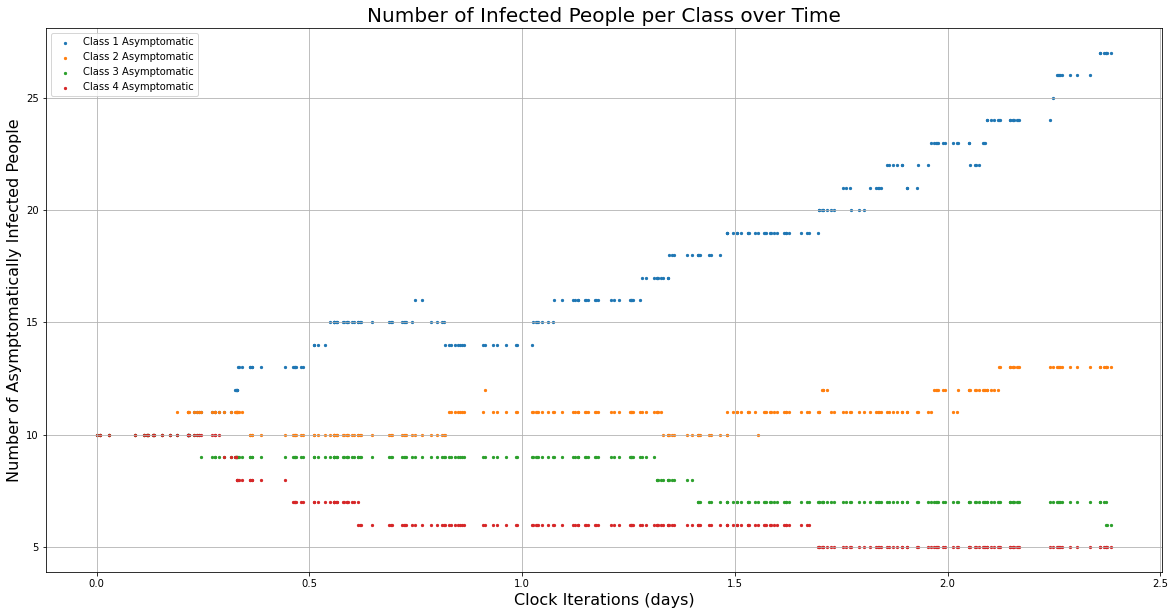

In [10]:
# example of what you can plot using the info dictionary
# adapted from code by Cornell University students Mohammad Kamil (mk848), Carrie Rucker (cmr284), Jacob Shusko (jws383), Kevin Van Vorst (kpv23)

clocks = info['clock times']
c1_A = info['c1 asymptomatic']
c2_A = info['c2 asymptomatic']
c3_A = info['c3 asymptomatic']
c4_A = info['c4 asymptomatic']

figsizex = 20
figsizey = 10
xlabelsize = 16
ylabelsize = xlabelsize
titlesize = 20

%matplotlib inline

fig = plt.figure(figsize=(figsizex,figsizey))
ax1 = fig.add_subplot(111)

ax1.scatter(clocks, c1_A, s=5, marker="o", label='Class 1 Asymptomatic')
ax1.scatter(clocks, c2_A, s=5, marker="o", label='Class 2 Asymptomatic')
ax1.scatter(clocks, c3_A, s=5, marker="o", label='Class 3 Asymptomatic')
ax1.scatter(clocks, c4_A, s=5, marker="o", label='Class 4 Asymptomatic')
plt.legend(loc='upper left');
plt.ylabel('Number of Asymptomatically Infected People',size=ylabelsize)
plt.xlabel('Clock Iterations (days)',size=xlabelsize)
plt.title("Number of Infected People per Class over Time",size=titlesize)
plt.grid(True)
plt.show()

### Heuristic Agents

We currently have a single heuristic agent implemented.  This algorithm picks a fixed priority order over the different classes and allocates according to that priority order.